In [1]:
%reset
# !module load texlive
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import matplotlib
%matplotlib inline

import pickle as pk
import numpy as np
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
import torch

dev = torch.device("cuda")
# torch.cuda.set_device(dev)
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.distributions import Normal
# change the root directory for this notebook

root_dir = '/mnt/home/spandey/ceph/AR_NPE/'
os.chdir(root_dir)
import colossus
import sys, os
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
from tqdm import tqdm
%load_ext autoreload
%autoreload 2




In [2]:
import colossus
# set cosmology
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
Mmin=13.1
Mmax=16.0
lgM_array = np.linspace(Mmin, Mmax, 1000)
M_array = 10**lgM_array
# hmf_tinker = mass_function.massFunction(M_array, 0, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
# hmf_sheth99 = mass_function.massFunction(M_array, 0, mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
hmf_bh11 = mass_function.massFunction(M_array, 0, mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = (lgM_array - Mmin)/(Mmax-Mmin) -0.5

int_val = sp.integrate.simps(hmf_bh11, lgM_rescaled)
hmf_bh11_pdf = hmf_bh11/int_val
# define the cdf of the halo mass function
hmf_bh11_cdf = np.zeros_like(hmf_bh11_pdf)
for i in range(len(hmf_bh11_cdf)):
    hmf_bh11_cdf[i] = sp.integrate.simps(hmf_bh11_pdf[:i+1], lgM_rescaled[:i+1])

    


In [3]:
ji = 0
# ns_d = 128
ns_d = 256
# ns_d = 512
nb = 8
nax_d = ns_d // nb
nf = 3
layers_types = ['res', 'res', 'res', 'res']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

# z=127 is the initial condition
z_all = [0, 127, 'z_0_diff_sig_1', 'z_0_diff_sig_3']
z_all_FP = [0, 99, 'z_0_diff_sig_1', 'z_0_diff_sig_3']
# z_all = [0]
# ns_h = 128
ns_h = 256
nax_h = ns_h // nb

nsims_per_batch = 32
# nbatches_train = nb**3//nsims_per_batch
nbatches_train = 16






In [4]:
print(nbatches_train)


16


In [5]:
hidden_dim_MAF = 5
learning_rate = 0.01
K_M1 = 5
B_M1 = 0.5
nflows_M1_NSF = 5

K_Mdiff = 5
B_Mdiff = 3
nflows_Mdiff_NSF = 3

# base_dist_M1 = 'gumbel'
# base_dist_M1 = 'gauss'
base_dist_M1 = 'physical_hmf'
base_dist_Mdiff = 'gumbel'
ngauss_M1 = 5

changelr = False
ksize = nf
nfeature_cnn = 4
nout_cnn = 4 * nfeature_cnn
ninp = len(z_all)
num_cond = nout_cnn + ninp



In [6]:
# Load the density data
df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train = load_density_halo_data_NGP(
    ji, ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    )

# # Prepare the density and halo data
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims_per_batch,
    nbatches = nbatches_train, rescaleM_sub=-0.5
    )





0 32
32 64
64 96
96 128
128 160
160 192
192 224
224 256
256 288
288 320
320 352
352 384
384 416
416 448
448 480
480 512


In [7]:
df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP = load_density_halo_data_NGP(
    ji, ns_d, nb, nf, nc, z_all_FP, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm'
    )

# # Prepare the density and halo data
return_dict_train_FP = prep_density_halo_cats_batched(
    df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, nsims=nsims_per_batch,
    nbatches = nbatches_train, rescaleM_sub=-0.5
    )





0 32
32 64
64 96
96 128
128 160
160 192
192 224
224 256
256 288
288 320
320 352
352 384
384 416
416 448
448 480
480 512


In [8]:
model_Ntot = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond,
    ngauss=return_dict_train['ngauss_Nhalo'],
    mu_all=return_dict_train['mu_all'],
    sig_all=return_dict_train['sig_all'],
    # base_dist=None
    base_dist='pl_exp'    
    )
# model_Ntot.to(dev)

model_M1 = NSF_M1_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond + 3,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    # mu_pos=False
    mu_pos=True,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_bh11_pdf,
    hmf_cdf_tointerp=hmf_bh11_cdf    
    )

model_M1.to(dev)

ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
model_Mdiff = NSF_Mdiff_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond + 2,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )
# model_Mdiff.to(dev)

print()



In [9]:
ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_Ntot,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Ntot_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    )

model.to(dev)

print()




In [10]:
np.array(return_dict_train['df_d_all']).shape
# np.array(return_dict_train['df_d_all_nsh']).shape


(16, 32, 4, 48, 48, 48)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_all_it = []
loss_min = 1e20


In [12]:
# cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all'])).cuda(dev)
# # cond_tensor_nsh = torch.Tensor(np.copy(return_dict_train['df_d_all_nsh'].reshape(nsims * (nax_h ** 3), ninp))).cuda(dev)
# cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
# print(cond_nsh.shape)
# cond_tensor_nsh = torch.Tensor(np.array(cond_nsh).reshape(nbatches_train,nsims_per_batch * (nax_h ** 3), ninp)).cuda(dev)
# mask_tensor_M1_train = torch.Tensor(np.array(return_dict_train['mask_M1']).reshape(nbatches_train,nsims_per_batch * (nax_h**3))).cuda(dev)
# mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict_train['mask_M_diff']).reshape(nbatches_train,nsims_per_batch * (nax_h**3),
#                                                                                  ndim_diff))).cuda(dev)

# X_M1 = torch.Tensor((np.array(return_dict_train['M1_halos_all_norm']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1))).cuda(dev)
# X_Nhalo = torch.Tensor(np.array(return_dict_train['Nhalo_train_mg_arr']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1)).cuda(dev)
# X_Mdiff = torch.Tensor(np.array(return_dict_train['M_diff_halos_all_norm_masked']).reshape(nbatches_train,nsims_per_batch * (nax_h**3),
#                                                                                  ndim_diff)).cuda(dev)
# Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1)))).cuda(dev)



In [13]:
# print(X_Mdiff.shape)



In [50]:
# save_bestfit_model_name = 'FINAL_COMBINED/BATCHED_model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
#                 str(nf) + '_nsh' + str(ns_h) + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train)
save_bestfit_model_name = 'COND_HMF_CHECKPOINTS/TEST_FINALS_M1_only_zall_nsf5_mixgaussplexp_BATCHED_model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
                str(nf) + '_nc' + str(nc) + '_nsh' + str(ns_h) + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train)

bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])



In [51]:
# train_Ntot, train_M1, train_Mdiff = 1, 1, 0
# train_Ntot, train_M1, train_Mdiff = 0, 0, 1
train_Ntot, train_M1, train_Mdiff = 0, 1, 0



In [52]:
# cond_tensor.shape
# 16 * 32 * 3 * 70 * 70 * 70



In [53]:
# ninit = 0
# niterations = 400

# # torch.autograd.set_detect_anomaly(False)
# for ito in tqdm(range(niterations)):
#     optimizer.zero_grad()
#     for g in optimizer.param_groups:
#         # g['lr'] = 0.00025
#         g['lr'] = 0.025

#     it = ito + ninit

#     loss = model(
#         X_Mdiff,
#         X_M1,
#         X_Nhalo,
#         cond_x=cond_tensor,
#         cond_x_nsh=cond_tensor_nsh,
#         mask_Mdiff_truth_all=mask_tensor_Mdiff_train,
#         mask_M1_truth_all=mask_tensor_M1_train,
#         Nhalos_truth_all=Nhalos_truth_tensor,
#         use_Ntot_samples=False,
#         use_M1_samples=False,
#         train_Ntot=train_Ntot,
#         train_M1=train_M1,
#         train_Mdiff=train_Mdiff       
#         )

#     loss.backward()
#     optimizer.step()

#     if (np.mod(it, int(niterations / 20)) == 0) or (it == niterations - 1):
#         if float(loss.cpu().detach().numpy()) < loss_min:
#             loss_min = float(loss.cpu().detach().numpy())
#             # print(loss1.detach().numpy(), loss2.detach().numpy(), loss3.detach().numpy())
#             print('saving bf at:', ', with loss:', np.round(loss_min, 4))
#             # print('saving bf at:', it, ', with loss:', np.round(loss_min, 9))
#             state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}

#             torch.save(
#                 state, save_bestfit_model_name
#                 )


            

In [54]:
# torch.cuda.empty_cache()



In [55]:
# cond_tensor.shape
# train_M1
# cond_tensor_nsh.shape




In [56]:
# cond_tensor = cond_tensor.to(dev)
# cond_tensor_nsh = cond_tensor_nsh.to(dev)
# Ntot_samp, M1_samp, M_diff_samp, mask_tensor_M1_samp, mask_tensor_Mdiff_samp = model.inverse(
#         cond_x=cond_tensor,
#         cond_x_nsh=cond_tensor_nsh,
#         use_truth_Nhalo=1-train_Ntot,
#             use_truth_M1=1-train_M1,
#             use_truth_Mdiff=1-train_Mdiff,    
#             mask_Mdiff_truth=mask_tensor_Mdiff_train,
#             mask_M1_truth=mask_tensor_M1_train,
#             Nhalos_truth=X_Nhalo,
#             Mdiff_truth=X_Mdiff,
#             M1_truth=X_M1,
#             train_Ntot=train_Ntot,
#             train_M1=train_M1,
#             train_Mdiff=train_Mdiff 
#         )








In [57]:
# train_Mdiff
# Nhalos_truth_tensor.shape
# 2097152/1048576
# mask_tensor_M1_train.shape, X_M1.shape
# cond_tensor.shape
# nsim * nvox // nbatches
# 128**3//8


In [58]:
# np.amin(cond_tensor_nsh.cpu().detach().numpy()[:,0])


In [59]:
# pl.figure()
# jb = 0
# indsel = np.where(cond_tensor_nsh[jb].cpu().detach().numpy()[:,0] > 0.0)
# _ = pl.hist(Ntot_samp[jb][indsel], histtype='step', bins=[0,1,2,3,4,5,6,7])
# _ = pl.hist(Nhalos_truth_tensor[jb].cpu().detach().numpy()[indsel], bins=[0,1,2,3,4,5,6,7])
# # xarr = np.arange(9)
# # yarr = 4e5*np.exp(-xarr)
# # al, bt = 0.0, 1.5
# # yarr = 4e5*np.power(1+xarr, al) * np.exp(-bt * xarr)
# # yarr = 4e5/xarr**(5)
# # pl.plot(xarr, yarr)
# # _ = pl.hist(X_Nhalo[:,0].cpu().detach().numpy())
# pl.yscale('log')
# pl.xlabel('Nhalo')
# pl.ylabel('Histogram')






In [60]:
# mask_tensor_M1_samp[jb].cpu().detach().numpy().shape
# M1_samp[0].shape, mask_tensor_M1_samp[0].shape
# mask_tensor_M1_train[0].shape



In [61]:
# pl.figure()
# indp = (mask_tensor_M1_samp[jb][:,0].cpu().detach().numpy() > 0)
# _ = pl.hist(M1_samp[jb].cpu().detach().numpy()[indp], range=(0,5), bins=100, histtype='step')
# indp = (mask_tensor_M1_train[jb].cpu().detach().numpy() > 0)
# _ = pl.hist(X_M1[jb][:,0].cpu().detach().numpy()[indp], range=(0,5), bins=100)
# pl.yscale('log')
# pl.xlabel('M1')
# pl.xlim(0,1)
# pl.ylabel('Histogram')








In [62]:
# X_Mdiff[0].shape




In [63]:
# mask_tensor_Mdiff_samp[0].shape, mask_tensor_Mdiff_train[0].shape, M_diff_samp[0].shape, X_Mdiff[0].shape




In [64]:
# pl.figure()
# ind_M = 0

# indp = mask_tensor_Mdiff_samp[jb][:, ind_M] > 0
# _ = pl.hist(M_diff_samp[jb][indp,ind_M].cpu().detach().numpy(), range=(0,0.5), histtype='step')
# indp = mask_tensor_Mdiff_train[jb][:, ind_M] > 0
# _ = pl.hist(X_Mdiff[jb][indp,ind_M].cpu().detach().numpy(), range=(0,0.5))


# pl.yscale('log')
# pl.xlabel(r'Mj-Mi')
# pl.ylabel('Histogram')






In [65]:
# nax_h
# cond_tensor_test.shape
# cond_nsh_test.shape
torch.cuda.empty_cache()

In [66]:
# now we load the test data
nstart = 0
nsims_test = 32
df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test = load_density_halo_data_NGP(
    0, ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    )

df_d_all_test_FP, df_d_all_nsh_test_FP, df_Mh_all_test_FP, df_Nh_test_FP = load_density_halo_data_NGP(
    0, ns_d, nb, nf, nc, z_all_FP, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm'
    )

# things are too big to load all at once, so we load in batches
nq = nb**3 // nsims_test
save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
cond_z0_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
save_subvol_M1_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
save_subvol_Mdiff_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
mask_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))

nfeatures_M1_tot = 20
cond_inp_M1_all = np.zeros((nb**3, nax_h, nax_h, nax_h, nfeatures_M1_tot))
density_out_M1_loc_all_pad = np.zeros((nb**3, nax_h+6, nax_h+6, nax_h+6))
density_out_M1_loc_all = np.zeros((nb**3, nax_h, nax_h, nax_h))

nscount = 0
for jq in range(nq):
    # Load the density data


    # Prepare the density and halo data
    return_dict_test = prep_density_halo_cats(
        df_d_all_test,
        df_d_all_nsh_test,
        df_Mh_all_test,
        df_Nh_test,
        nsims=nsims_test,
        nstart=nscount,
        rescaleM_sub=-0.5
        )
    
    return_dict_test_FP = prep_density_halo_cats(
        df_d_all_test_FP,
        df_d_all_nsh_test_FP,
        df_Mh_all_test_FP,
        df_Nh_test_FP,
        nsims=nsims_test,
        nstart=nscount,
        rescaleM_sub=-0.5
        )    

    cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test_FP['df_d_all']]))).cuda(dev)
    cond_nsh_test = np.moveaxis(return_dict_test_FP['df_d_all_nsh'], 1, 4)
    cond_nsh_test = np.array([cond_nsh_test])
    # print(np.array([cond_nsh_test]).shape)
    cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)    
    # cond_tensor_nsh_test = torch.Tensor(
    #     np.copy(return_dict_test['df_d_all_nsh'].reshape(nsims_test * (nax_h**3), ninp))
    #     ).cuda(dev)
    mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
    mask_tensor_Mdiff_test = torch.Tensor(
        (return_dict_test['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
        ).cuda(dev)

    X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
    X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
    X_Mdiff_test = torch.Tensor(
        return_dict_test['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
        ).cuda(dev)
    Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                      1)))).cuda(dev)
    

    mask_tensor_M1_test_FP = torch.Tensor(np.copy(return_dict_test_FP['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
    mask_tensor_Mdiff_test_FP = torch.Tensor(
        (return_dict_test_FP['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
        ).cuda(dev)

    X_M1_test_FP = torch.Tensor((return_dict_test_FP['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
    X_Nhalo_test_FP = torch.Tensor(return_dict_test_FP['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
    X_Mdiff_test_FP = torch.Tensor(
        return_dict_test_FP['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
        ).cuda(dev)
    Nhalos_truth_tensor_test_FP = torch.Tensor(((return_dict_test_FP['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                      1)))).cuda(dev)


    Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, cond_inp_M1_test = model.inverse(
        cond_x=cond_tensor_test,
        cond_x_nsh=cond_tensor_nsh_test,
        use_truth_Nhalo=1-train_Ntot,
            use_truth_M1=1-train_M1,
            use_truth_Mdiff=1-train_Mdiff, 
        mask_Mdiff_truth=mask_tensor_Mdiff_test,
        mask_M1_truth=mask_tensor_M1_test,
        Nhalos_truth=X_Nhalo_test,
        M1_truth=X_M1_test,
        Mdiff_truth=X_Mdiff_test,
        train_Ntot=train_Ntot,
        train_M1=train_M1,
        train_Mdiff=train_Mdiff,
        x_M1_FP=X_M1_test_FP,   
        mask_M1_truth_all_FP=mask_tensor_M1_test_FP 
        )
    Ntot_samp_test = Ntot_samp_test[0][:,np.newaxis]
    # print(Ntot_samp_test.shape)
    save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
    save_subvol_Nhalo_truth[nscount:nscount + nsims_test, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
    save_subvol_M1[nscount:nscount + nsims_test,
                   ...] = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:,0]
                          ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
    save_subvol_M1_truth[nscount:nscount + nsims_test,
                   ...] = (X_M1_test[0][:,0] * mask_tensor_M1_test[0]
                          ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)    
    # cond_inp_M1_all[nscount:nscount + nsims_test,
    #                ...] = cond_inp_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, nfeatures_M1_tot)
    # density_out_M1_loc_all_pad[nscount:nscount + nsims_test,...] = (cond_tensor_test[0,:,0,...].cpu().detach().numpy())
    # density_out_M1_loc_all[nscount:nscount + nsims_test,...] = (cond_nsh_test[0,...,0])

    save_subvol_Mdiff[nscount:nscount + nsims_test,
                      ...] = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                             ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
    
    save_subvol_Mdiff_truth[nscount:nscount + nsims_test,
                      ...] = (X_Mdiff_test[0] * mask_tensor_Mdiff_test[0]
                             ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
    
    mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
                     0] = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
    mask_subvol_Mtot[
        nscount:nscount + nsims_test, ...,
        1:] = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

    mask_subvol_Mtot_truth[nscount:nscount + nsims_test, ...,
                     0] = mask_tensor_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
    mask_subvol_Mtot_truth[
        nscount:nscount + nsims_test, ...,
        1:] = mask_tensor_Mdiff_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
    
    
    cond_z0_truth[nscount:nscount + nsims_test, ...] = cond_tensor_nsh_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ninp)[...,0]
    # print(nscount, nscount + nsims_test)

    nscount += nsims_test
    torch.cuda.empty_cache()


    
    
    

0 32
0 32
32 64
32 64
64 96
64 96
96 128
96 128
128 160
128 160
160 192
160 192
192 224
192 224
224 256
224 256
256 288
256 288
288 320
288 320
320 352
320 352
352 384
352 384
384 416
384 416
416 448
416 448
448 480
448 480
480 512
480 512


In [67]:
# 64*32*32*32*20
# cond_inp_M1_test[0].shape




In [68]:
# 64*32*32*32*20, 2097152 * 21


In [69]:
save_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
for jd in range(ndim_diff + 1):
    if jd == 0:
        save_subvol_Mtot[..., jd] = (save_subvol_M1[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
    else:
        save_subvol_Mtot[...,
                         jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (Mmax - Mmin)


save_subvol_Mtot *= mask_subvol_Mtot

ind_less_Mmin = save_subvol_Mtot < Mmin
ind_greater_Mmax = save_subvol_Mtot > Mmax
save_subvol_Mtot[ind_less_Mmin] = 0.0
save_subvol_Mtot[ind_greater_Mmax] = 0.0


        
    
    

In [70]:
save_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
for jd in range(ndim_diff + 1):
    if jd == 0:
        save_subvol_Mtot_truth[..., jd] = (save_subvol_M1_truth[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
    else:
        save_subvol_Mtot_truth[...,
                         jd] = (save_subvol_Mtot_truth[..., jd - 1]) - (save_subvol_Mdiff_truth[..., jd - 1]) * (Mmax - Mmin)


save_subvol_Mtot_truth *= mask_subvol_Mtot_truth

# ind_less_Mmin = save_subvol_Mtot < Mmin
# ind_greater_Mmax = save_subvol_Mtot > Mmax
# save_subvol_Mtot[ind_less_Mmin] = Mmin
# save_subvol_Mtot[ind_greater_Mmax] = Mmax


        
    
    

In [71]:
# np.amin(save_subvol_Mtot_truth), np.amax(save_subvol_Mtot_truth)
np.amin(save_subvol_Mtot), np.amax(save_subvol_Mtot)

(0.0, 15.646037405729293)

In [72]:
# # # mask_tensor_M1_samp_test[0].shape, M1_samp_test[0].shape
# # print(cond_inp_M1_all.shape, density_out_M1_loc_all.shape, save_subvol_Nhalo_truth.shape)
# # print(save_subvol_Mtot[...,0].shape, save_subvol_Mtot_truth[...,0].shape)
# # os.getcwd()
# import h5py

# # Create a new HDF5 file
# with h5py.File('save_M1_GNN_data.h5', 'r') as f:
#     print(f.keys())



In [73]:
# import h5py

# with h5py.File('save_M1_GNN_data.h5', 'w') as f:
#     dset = f.create_dataset('DM_overdensity_unpadded', data=density_out_M1_loc_all)
#     dset.attrs['description'] = 'This dataset contains the DM over desntiy field. This has shape of (n_subbox, nvox_subbox, nvox_subbox, nvox_subbox)'

#     dset = f.create_dataset('DM_overdensity_padded', data=density_out_M1_loc_all_pad)
#     dset.attrs['description'] = 'This dataset contains the features extracted from CNNs to get the M1 distribution correct. This has shape of (n_subbox, nvox_subbox, nvox_subbox, nvox_subbox, nfeatures)'

#     dset = f.create_dataset('CNN_cond_M1', data=cond_inp_M1_all)
#     dset.attrs['description'] = 'This dataset contains the padded DM over desntiy field. This has shape of (n_subbox, nvox_subbox+npad, nvox_subbox+npad, nvox_subbox+npad)'

#     dset = f.create_dataset('Nhalos_truth', data=save_subvol_Nhalo_truth)
#     dset.attrs['description'] = 'This dataset contains the true number of halos in each voxel. This has shape of (n_subbox, nvox_subbox, nvox_subbox, nvox_subbox)'

#     dset = f.create_dataset('M1_truth', data=save_subvol_Mtot_truth[...,0])
#     dset.attrs['description'] = 'This dataset contains the true mass of the heaviest halo in each voxel. This has shape of (n_subbox, nvox_subbox, nvox_subbox, nvox_subbox)'

#     dset = f.create_dataset('M1_predicted', data=save_subvol_Mtot[...,0])
#     dset.attrs['description'] = 'This dataset contains the predicted mass of the heaviest halo in each voxel. This has shape of (n_subbox, nvox_subbox, nvox_subbox, nvox_subbox)'




In [74]:
# pl.figure()
# pl.imshow(density_out_M1_loc_all[128,16,...])
# pl.figure()
# pl.imshow(density_out_M1_loc_all_pad[128,19,...])
# # pl.figure()
# # pl.imshow(save_subvol_Mtot[128,16,...,0])
# # pl.figure()
# # pl.imshow(save_subvol_Mtot_truth[128,16,...,0])



In [75]:
# pl.imshow(save_subvol_Nhalo_truth[128,16,...], vmin=0, vmax=5)
# pl.figure()
# pl.imshow(save_subvol_Mtot[128,16,...,0], vmin=13, vmax=16)
# pl.figure()
# pl.imshow(save_subvol_Mtot_truth[128,16,...,0], vmin=13, vmax=16)



In [76]:
# import h5py

# with h5py.File('save_M1_GNN_data.h5', 'r') as df:
#     DM_overdensity_unpadded_all = np.exp(df['DM_overdensity_unpadded'][()]) - 1
#     DM_overdensity_padded_all = np.exp(df['DM_overdensity_padded'][()]) - 1
#     CNN_cond_M1_all = df['CNN_cond_M1'][()]
#     Nhalos_truth_all = df['Nhalos_truth'][()]
#     M1_truth_all = df['M1_truth'][()]
#     M1_predicted_all = df['M1_predicted'][()]
    



# nsims, nax_h = M1_predicted_all.shape[0], M1_predicted_all.shape[1]

# xall = (np.linspace(0, 1000/(nsims**(1/3)), nax_h + 1))
# xarray = 0.5 * (xall[1:] + xall[:-1])
# dx = (xall[1] - xall[0])
# yarray = np.copy(xarray)
# zarray = np.copy(xarray)
# x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

# def get_all_data_vec(jsim_select):
#     nsim_j = len(jsim_select)
#     x_cy_rep, y_cy_rep, z_cy_rep = np.tile(x_cy, (nsim_j, 1, 1, 1)), np.tile(y_cy, (nsim_j, 1, 1, 1)), np.tile(z_cy, (nsim_j, 1, 1, 1))
#     DM_overdensity_jsim = DM_overdensity_unpadded_all[jsim_select, ...]
#     CNN_cond_M1_jsim = CNN_cond_M1_all[jsim_select, ...]
#     Nhalos_truth_jsim = Nhalos_truth_all[jsim_select, ...]
#     M1_truth_jsim = M1_truth_all[jsim_select, ...]
#     M1_predicted_jsim = M1_predicted_all[jsim_select, ...]
#     indsel = np.where(Nhalos_truth_jsim > 0)
#     x_cy_rep, y_cy_rep, z_cy_rep = x_cy_rep[indsel], y_cy_rep[indsel], z_cy_rep[indsel]
#     DM_overdensity_jsim, CNN_cond_M1_jsim = DM_overdensity_jsim[indsel], CNN_cond_M1_jsim[indsel]
#     M1_truth_jsim, M1_predicted_jsim = M1_truth_jsim[indsel], M1_predicted_jsim[indsel]
#     Nhalos_jsim = Nhalos_truth_jsim[indsel]
#     return x_cy_rep, y_cy_rep, z_cy_rep, DM_overdensity_jsim, CNN_cond_M1_jsim, M1_truth_jsim, M1_predicted_jsim, Nhalos_jsim

    




In [77]:
# jsim_select = np.array([1,2])
# nsim_j = len(jsim_select)
# x_cy_rep, y_cy_rep, z_cy_rep = np.tile(x_cy, (nsim_j, 1, 1, 1)), np.tile(y_cy, (nsim_j, 1, 1, 1)), np.tile(z_cy, (nsim_j, 1, 1, 1))
# DM_overdensity_jsim = DM_overdensity_unpadded_all[jsim_select, ...]
# CNN_cond_M1_jsim = CNN_cond_M1_all[jsim_select, ...]
# Nhalos_truth_jsim = Nhalos_truth_all[jsim_select, ...]
# M1_truth_jsim = M1_truth_all[jsim_select, ...]
# M1_predicted_jsim = M1_predicted_all[jsim_select, ...]
# indsel = np.where(Nhalos_truth_jsim > 0)
# x_cy_rep, y_cy_rep, z_cy_rep = x_cy_rep[indsel], y_cy_rep[indsel], z_cy_rep[indsel]
# DM_overdensity_jsim, CNN_cond_M1_jsim = DM_overdensity_jsim[indsel], CNN_cond_M1_jsim[indsel]
# M1_truth_jsim, M1_predicted_jsim = M1_truth_jsim[indsel], M1_predicted_jsim[indsel]
# Nhalos_jsim = Nhalos_truth_jsim[indsel]


In [78]:
# indsel
# CNN_cond_M1_jsim.shape
# np.amin(DM_overdensity_unpadded_all), np.amax(DM_overdensity_unpadded_all)


In [79]:
sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
# load the halo data
fname = sdir + '/' + str(0) + '/halos_subvol_res_' + str(ns_h) + '_z=0.pk'
df_h = pk.load(open(fname, 'rb'))
# This has information on the halo mass for all the halos in the voxel
df_Mh_all_truth = df_h['M_halos']
df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# This has information on the number of halos in the voxel
df_Nh_truth = df_h['N_halos']

fname = sdir + '/' + str(0) + '/halos_full_res_' + str(ns_h) + '_z=0.pk'
df_h = pk.load(open(fname, 'rb'))
df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']




In [80]:
# delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
# # delta_min_p, delta_max_p =1.0, 1.5
# delta_min_p, delta_max_p =0.0, 100
# # delta_min_p, delta_max_p = 2, 5
# # delta_min_p, delta_max_p = -0.5, -0.0
# # delta_min_p, delta_max_p = 1.0, 2.0
# indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
# pl.figure(figsize=(8,6))
# bin_cents = np.array([0,1,2,3,4,5,6,7,8])
# bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
# bin_edges = np.insert(bin_edges,0, -0.5)
# bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
# hist_truth, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
# # _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8], label='Truth')
# pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')
# hist_samp, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
# # _ = pl.hist(, bins=[0,1,2,3,4,5,6,7,8], label='Sampled')
# pl.plot(bin_cents, hist_samp, marker='o', color='b', ls='-', label='Sampled')
# pl.yscale('log')
# pl.legend(fontsize=15, frameon=False)
# pl.tick_params(axis='both', which='major', labelsize=15)
# pl.tick_params(axis='both', which='minor', labelsize=15)
# pl.xlabel(r'$N_{\rm halo}$', size=18)
# pl.ylabel('Histogram', size=18)
# pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)






Text(0.5, 1.0, '-1.0$< \\delta_m < $500.0')

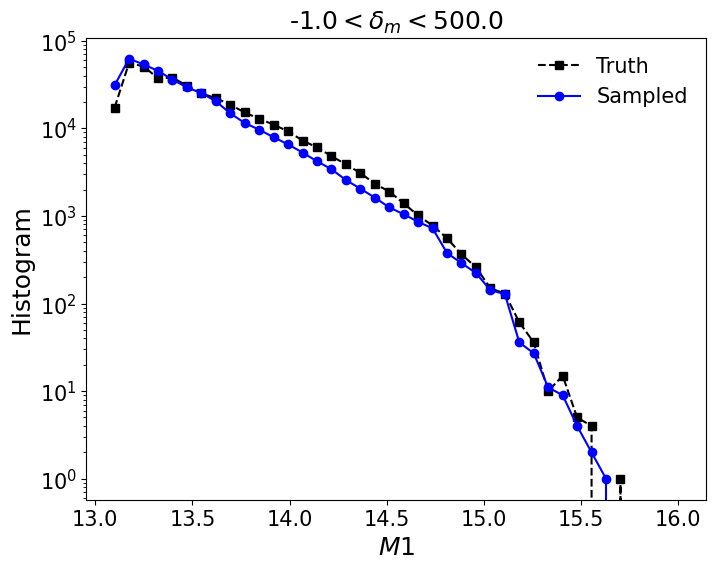

In [81]:
delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
delta_min_p, delta_max_p = -1.0, 500.0
# delta_min_p, delta_max_p = -0.5, -0.0
# delta_min_p, delta_max_p = 20.0, 100.0
# delta_min_p, delta_max_p = 5.0, 20.0
# delta_min_p, delta_max_p = 20.0, 200.0
# delta_min_p, delta_max_p = 5.0, 20.0
# delta_min_p, delta_max_p = 3.0, 10.0
# delta_min_p, delta_max_p = 0.0, 1.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
pl.figure(figsize=(8,6))
bin_cents = np.linspace(13.1, 16.0, 40)
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
delta_b = 0.5*(bin_cents[1] - bin_cents[0])
bin_edges = np.insert(bin_edges,0, bin_cents[0] - delta_b)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] - delta_b)

idim = 0
M_idim_truth = df_Mh_all_truth[..., idim]

hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8], label='Truth')
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')

M_idim_samp = save_subvol_Mtot[..., idim]
hist_samp, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(, bins=[0,1,2,3,4,5,6,7,8], label='Sampled')
pl.plot(bin_cents, hist_samp, marker='o', color='b', ls='-', label='Sampled')
pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$M$' + str(idim + 1), size=18)
pl.ylabel('Histogram', size=18)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)








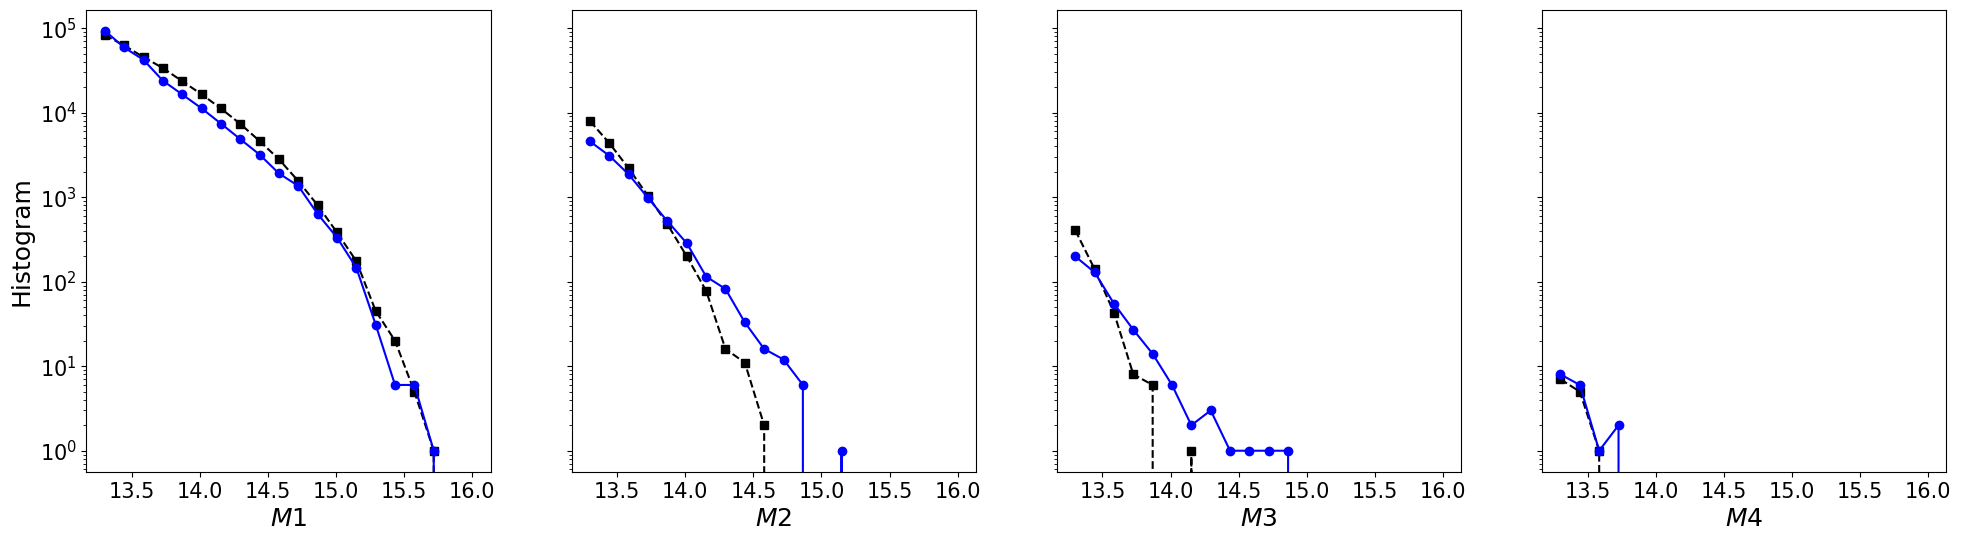

In [25]:
# make a four panel figure with idim going from 0 to 3 in the rows:

delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
delta_min_p, delta_max_p = -1.0, 500.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
bin_cents = np.linspace(13.3, 16.0, 20)
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
delta_b = 0.5*(bin_cents[1] - bin_cents[0])
bin_edges = np.insert(bin_edges,0, bin_cents[0] - delta_b)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] - delta_b)

fig, ax = pl.subplots(1,4, figsize=(24,6), sharey=True, sharex=True)
for idim in range(4):
    M_idim_truth = df_Mh_all_truth[..., idim]
    hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
    ax[idim].plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')
    
    M_idim_samp = save_subvol_Mtot[..., idim]
    hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges)
    ax[idim].plot(bin_cents, hist_sampled, marker='o', color='b', ls='-', label='Sampled')
    ax[idim].set_yscale('log')
    ax[idim].tick_params(axis='both', which='major', labelsize=15)
    ax[idim].tick_params(axis='both', which='minor', labelsize=15)
    
    if idim == 0:
        ax[idim].set_ylabel('Histogram', size=18)
    ax[idim].set_xlabel(r'$M$' + str(idim + 1), size=18)



Text(0.5, 1.0, '-1.0$< \\delta_m < $50.0')

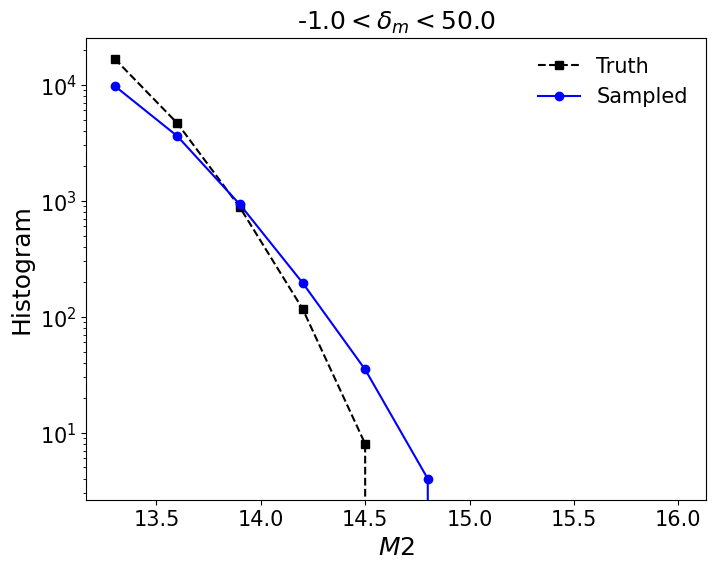

In [47]:
delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
# delta_min_p, delta_max_p = -1.0, -0.5
# delta_min_p, delta_max_p = -0.5, -0.0
# delta_min_p, delta_max_p = -1.0, 0.0
# delta_min_p, delta_max_p = 0.0, 1.0
delta_min_p, delta_max_p = -1.0, 50.0
# delta_min_p, delta_max_p = 3.0, 10.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
pl.figure(figsize=(8,6))
bin_cents = np.linspace(13.3, 16.0, 10)
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
delta_b = 0.5*(bin_cents[1] - bin_cents[0])
bin_edges = np.insert(bin_edges,0, bin_cents[0] - delta_b)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] - delta_b)

idim = 1
M_idim_truth = df_Mh_all_truth[..., idim]

hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8], label='Truth')
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')

M_idim_samp = save_subvol_Mtot[..., idim]
hist_samp, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(, bins=[0,1,2,3,4,5,6,7,8], label='Sampled')
pl.plot(bin_cents, hist_samp, marker='o', color='b', ls='-', label='Sampled')
pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$M$' + str(idim + 1), size=18)
pl.ylabel('Histogram', size=18)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)






In [82]:
# create empty arrays for Nhalos and M_halos
Nhalos = np.zeros((ns_h, ns_h, ns_h))
M_halos = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))
M_halos_truth = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

subvol_size = ns_h // nb

ind_cart_lin = {}
ind_lin_cart = {}
jc = 0
from tqdm import tqdm
for jx in tqdm(range(nb)):
    for jy in range(nb):
        for jz in range(nb):
            # get the sub-cube
            ind_lin_cart[(jx, jy, jz)] = jc
            ind_cart_lin[jc] = [jx, jy, jz]
            jc += 1
            

# iterate over subvolumes
jc = 0
for jx in range(nb):
    for jy in range(nb):
        for jz in range(nb):
            # update Nhalos and M_halos with subvolumes
#             Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#                    jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[jc]

#             M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#                     jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[jc]

            Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                   jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[ind_lin_cart[(jx, jy, jz)]]

            M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[ind_lin_cart[(jx, jy, jz)]]
            
            
            jc += 1
            
            
            

100%|██████████| 8/8 [00:00<00:00, 28581.29it/s]


In [83]:
# create empty arrays for Nhalos and M_halos
Nhalos_truth_recomb = np.zeros((ns_h, ns_h, ns_h))
M_halos_truth_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

subvol_size = ns_h // nb

ind_cart_lin = {}
ind_lin_cart = {}
jc = 0
from tqdm import tqdm
for jx in tqdm(range(nb)):
    for jy in range(nb):
        for jz in range(nb):
            # get the sub-cube
            ind_lin_cart[(jx, jy, jz)] = jc
            ind_cart_lin[jc] = [jx, jy, jz]
            jc += 1
            

# iterate over subvolumes
jc = 0
for jx in range(nb):
    for jy in range(nb):
        for jz in range(nb):
            # update Nhalos and M_halos with subvolumes
#             Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#                    jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[jc]

#             M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#                     jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[jc]

            Nhalos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                   jz * subvol_size:(jz + 1) * subvol_size] = df_Nh_truth[ind_lin_cart[(jx, jy, jz)]]

            M_halos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size, :] = df_Mh_all_truth[ind_lin_cart[(jx, jy, jz)]]
            
            
            jc += 1
            

           
            


100%|██████████| 8/8 [00:00<00:00, 35887.09it/s]


In [84]:
# # M_halos.shape
M_halos[..., 1:] = M_halos_truth_recomb[...,1:]

# M_halos_truth_recomb.shape


In [85]:
# # Nhalos_truth_recomb.shape
# # pl.figure()
# # pl.imshow(np.log(np.abs(M_halos_truth_recomb[64,:,:,0] - M_halos[64,:,:,0])), origin='lower')
# # # pl.imshow(np.log(np.abs(M_halos_truth_recomb[64,:,:,0] - M_halos[64,:,:,0])), origin='lower')
# # pl.imshow(M_halos_truth_recomb[64,:,:,0], vmin=13, vmax=16, origin='lower')
# # pl.figure()
# # pl.imshow(, vmin=13, vmax=16, origin='lower')


# fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
# fig.subplots_adjust(wspace=0.1, hspace=0.1)

# # axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# # axes[0].set_title('Truth', size=18)
# xmin = 0
# xmax = 100
# axes[0].imshow(Nhalos[80,:,:], vmin=0, vmax=2, origin='lower')
# axes[0].set_title('AR-NPE', size=18)
# axes[0].set_xlim(xmin,xmax)
# axes[0].set_ylim(xmin,xmax)

# axes[1].imshow(Nhalos_truth_recomb[80,:,:], vmin=0, vmax=2, origin='lower')
# axes[1].set_title('Truth', size=18)
# axes[1].set_xlim(xmin,xmax)
# axes[1].set_ylim(xmin,xmax)

# # axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
# axes[2].imshow((np.abs(Nhalos_truth_recomb[80,:,:] - Nhalos[80,:,:])), vmin=0, vmax=2, origin='lower')
# axes[2].set_title('AR-NPE - Truth', size=18)
# axes[2].set_xlim(xmin,xmax)
# axes[2].set_ylim(xmin,xmax)






            

In [86]:
# pl.figure()
# pl.scatter(Nhalos[64,:,:].flatten() + 0.3*np.random.rand(len(Nhalos[64,:,:].flatten())), Nhalos_truth_recomb[64,:,:].flatten()+ 0.3*np.random.rand(len(Nhalos[64,:,:].flatten())), s=0.5)
# pl.plot([0,4],[0,4], color='k', ls='--', lw=1)
# pl.xlim(0,4)
# pl.ylim(0,4)



In [87]:
M_halos_truth_recomb.shape


(256, 256, 256, 5)

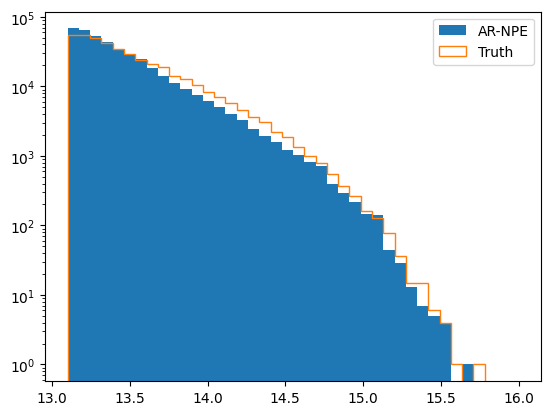

In [88]:
# ns_h
# pos_h_mock
pl.figure()
_ = pl.hist(M_halos.flatten(), range=(13.1, 16), bins=40, label='AR-NPE')
_ = pl.hist(M_halos_truth_recomb.flatten(), range=(13.1, 16),histtype='step', bins=40, label='Truth')
pl.yscale('log')
pl.legend()





In [89]:
# create the meshgrid
zv = 0.0
av = 1. / (1 + zv)
xall = (np.linspace(0, 1000, ns_h + 1))
xarray = av * 0.5 * (xall[1:] + xall[:-1])
yarray = np.copy(xarray)
zarray = np.copy(xarray)
x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')




In [90]:
# create the meshgrid
zv = 0.0
av = 1. / (1 + zv)
xall = (np.linspace(0, 1000, ns_h + 1))
xarray = av * 0.5 * (xall[1:] + xall[:-1])
dx = (xall[1] - xall[0])
yarray = np.copy(xarray)
zarray = np.copy(xarray)
x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
k = 0
for jx in range(ns_h):
    for jy in range(ns_h):
        for jz in range(ns_h):
                Nh_vox = int(Nhalos[jx, jy, jz])
                if Nh_vox > 0:
                    # for jh in range(Nh_vox):
                    # x_h_mock.append(x_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    # y_h_mock.append(y_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    # z_h_mock.append(z_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                    y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                    z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                    
                    lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
                    k += Nh_vox

# convert to numpy arrays
x_h_mock = np.concatenate(x_h_mock)
y_h_mock = np.concatenate(y_h_mock)
z_h_mock = np.concatenate(z_h_mock)
pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
lgMass_mock = np.concatenate(lgM_mock)
# convert to float data type
pos_h_mock = pos_h_mock.astype('float32')
lgMass_mock = lgMass_mock.astype('float32')

# import numpy as np
import h5py as h5
with h5.File('/mnt/home/spandey/ceph/AR_NPE/FINAL_run_models/mock_halo_ns' + str(ns_h) + '.h5', 'w') as f:
    # create a new dataset and write the data to it
    f.create_dataset('x_h', data=x_h_mock)
    f.create_dataset('y_h', data=y_h_mock)
    f.create_dataset('z_h', data=z_h_mock)
    f.create_dataset('lgMass', data=lgMass_mock)    
    f.close()

    


In [91]:

# sdir='/pscratch/sd/s/spandey/quijote/Snapshot_fid/Snapshot_fid_density'
# # load the halo data
# fname = sdir + '/' + str(0) + '/halo_data_dict_' + str(ns_h) + '.pk'
# df_h = pk.load(open(fname, 'rb'))
# # This has information on the halo mass for all the halos in the voxel
# df_Mh_all_truth = df_h['M_halos']
# df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# # This has information on the number of halos in the voxel
# df_Nh_truth = df_h['N_halos']

# df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']

sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
# load the halo data
fname = sdir + '/' + str(0) + '/halos_subvol_res_' + str(ns_h) + '_z=0.pk'
df_h = pk.load(open(fname, 'rb'))
# This has information on the halo mass for all the halos in the voxel
df_Mh_all_truth = df_h['M_halos']
df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# This has information on the number of halos in the voxel
df_Nh_truth = df_h['N_halos']

fname = sdir + '/' + str(0) + '/halos_full_res_' + str(ns_h) + '_z=0.pk'
df_h = pk.load(open(fname, 'rb'))
df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']




# create the meshgrid
zv = 0.0
av = 1. / (1 + zv)
xall = (np.linspace(0, 1000, ns_h + 1))
xarray = av * 0.5 * (xall[1:] + xall[:-1])
dx = (xall[1] - xall[0])
yarray = np.copy(xarray)
zarray = np.copy(xarray)
x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

x_h_truth, y_h_truth, z_h_truth, lgM_truth = [], [], [], []
for jx in range(ns_h):
    for jy in range(ns_h):
        for jz in range(ns_h):
                Nh_vox = int(df_Nh_truth_comb[jx, jy, jz])
                if Nh_vox > 0:
                    # for jh in range(Nh_vox):
                    # x_h_mock.append(x_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    # y_h_mock.append(y_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    # z_h_mock.append(z_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    x_h_truth.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                    y_h_truth.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                    z_h_truth.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                    
                    lgM_truth.append((df_Mh_all_truth_comb[jx, jy, jz, :Nh_vox]))

# convert to numpy arrays
x_h_truth = np.concatenate(x_h_truth)
y_h_truth = np.concatenate(y_h_truth)
z_h_truth = np.concatenate(z_h_truth)
pos_h_truth = np.vstack((x_h_truth, y_h_truth, z_h_truth)).T
lgMass_truth = np.concatenate(lgM_truth)
# convert to float data type
pos_h_truth = pos_h_truth.astype('float32')
lgMass_truth = lgMass_truth.astype('float32')

import numpy as np
import h5py as h5
with h5.File('/mnt/home/spandey/ceph/AR_NPE/FINAL_run_models/truth_halo_ns' + str(ns_h) + '.h5', 'w') as f:
    # create a new dataset and write the data to it
    f.create_dataset('x_h', data=x_h_truth)
    f.create_dataset('y_h', data=y_h_truth)
    f.create_dataset('z_h', data=z_h_truth)
    f.create_dataset('lgMass', data=lgMass_truth)    
    f.close()

    






In [92]:
# len(x_h_truth), len(x_h_mock)


In [93]:
# !pip install Pylians


In [94]:
# import MAS_library as MASL
import sys, os
from tqdm import tqdm
import readfof
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL



In [130]:
import readfof
import MAS_library as MASL
snap_dir_base='/mnt/home/spandey/ceph/Quijote/Halos/fiducial'
# load the corresponding halo catalogue
snapdir = snap_dir_base + '/' + str(0)  #folder hosting the catalogue
snapnum=4
# determine the redshift of the catalogue
# z_dict = {4: 0.0, 3: 0.5, 2: 1.0, 1: 2.0, 0: 3.0}
# redshift = z_dict[snapnum]

# read the halo catalogue
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)

# get the properties of the halos
pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

lgMass_truth = np.log10(mass_truth)

# Mmin_Pk, Mmax_Pk = 13.0, 100.0
Mmin_Pk, Mmax_Pk = 14.0, 14.5
# Mmin_Pk, Mmax_Pk = 13.5, 14.0
# Mmin_Pk, Mmax_Pk = 14.5, 16.0
# Mmin_Pk, Mmax_Pk = 13, 16
indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]

import numpy as np
import h5py as h5
with h5.File('/mnt/home/spandey/ceph/AR_NPE/FINAL_run_models/truth_halo_orig.h5', 'w') as f:
    # create a new dataset and write the data to it
    f.create_dataset('x_h', data=pos_h_truth[:,0])
    f.create_dataset('y_h', data=pos_h_truth[:,1])
    f.create_dataset('z_h', data=pos_h_truth[:,2])
    f.create_dataset('lgMass', data=lgMass_truth)    
    f.close()



print(len(indsel_Pk_truth))
# density field parameters
grid    = ns_h    #the 3D field will have grid x grid x grid voxels
BoxSize = 1000.0 #Mpc/h ; size of box
MAS     = 'NGP'  #mass-assigment scheme
verbose = True   #print information on progress


mesh_truth = np.zeros((grid, grid, grid), dtype=np.float32)
pos_truth = pos_h_truth[indsel_Pk_truth,...]
MASL.MA(pos_truth, mesh_truth, BoxSize, MAS)
mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
Pk_truth = PKL.Pk(mesh_truth, BoxSize, axis=0, MAS=MAS, threads=1)

# df_nbkit = {}
# lgM_samp = df_samp['lgM_samp_all_f']
# df_nbkit['Position'] = np.vstack((df_samp['x_samp_all'], df_samp['y_samp_all'], df_samp['z_samp_all'])).T
# df_nbkit['Position'] = pos_h_truth[indsel_Pk_truth,...]
# np.vstack((df_samp['x_samp_all'], df_samp['y_samp_all'], df_samp['z_samp_all'])).T.shape
# from nbodykit.source.catalog import ArrayCatalog
# cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
# mesh_truth = cat.to_mesh(window='nearest', Nmesh=grid, compensated=False, position='Position')
# mesh_truth = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')
# r = FFTPower(mesh_truth, mode='1d', dk=0.05)
# Pk_truth = r.power









31728

Computing power spectrum of the field...
Time to complete loop = 0.54
Time taken = 0.72 seconds


In [131]:
# mesh_truth.shape

In [132]:
import numpy
def fftk(shape, boxsize, symmetric=True, finite=False, dtype=np.float64):
    """ return kvector given a shape (nc, nc, nc) and boxsize 
    """
    k = []
    for d in range(len(shape)):
        kd = numpy.fft.fftfreq(shape[d])
        kd *= 2 * numpy.pi / boxsize * shape[d]
        kdshape = numpy.ones(len(shape), dtype='int')
        if symmetric and d == len(shape) -1:
            kd = kd[:shape[d]//2 + 1]
        kdshape[d] = len(kd)
        kd = kd.reshape(kdshape)

        k.append(kd.astype(dtype))
    del kd, kdshape
    return k


def power(f1, f2=None, boxsize=1.0, k = None, symmetric=True, demean=True, eps=1e-9):
    """
    Calculate power spectrum given density field in real space & boxsize.
    Divide by mean, so mean should be non-zero
    """
    if demean and abs(f1.mean()) < 1e-3:
        print('Add 1 to get nonzero mean of %0.3e'%f1.mean())
        f1 = f1*1 + 1
    if demean and f2 is not None:
        if abs(f2.mean()) < 1e-3:
            print('Add 1 to get nonzero mean of %0.3e'%f2.mean())
            f2 =f2*1 + 1
    
    if symmetric: c1 = np.fft.rfftn(f1)
    else: c1 = np.fft.fftn(f1)
    if demean : c1 /= c1[0, 0, 0].real
    c1[0, 0, 0] = 0
    if f2 is not None:
        if symmetric: c2 = np.fft.rfftn(f2)
        else: c2 = np.fft.fftn(f2)
        if demean : c2 /= c2[0, 0, 0].real
        c2[0, 0, 0] = 0
    else:
        c2 = c1
    #x = (c1 * c2.conjugate()).real
    x = c1.real* c2.real + c1.imag*c2.imag
    del c1
    del c2
    if k is None:
        k = fftk(f1.shape, boxsize, symmetric=symmetric)
        k = sum(kk**2 for kk in k)**0.5
    H, edges = numpy.histogram(k.flat, weights=x.flat, bins=f1.shape[0]) 
    N, edges = numpy.histogram(k.flat, bins=edges)
    center= edges[1:] + edges[:-1]
    power = H *boxsize**3 / N
    power[power == 0] = np.NaN
    return 0.5 * center,  power




In [133]:
# Pk_truth_new = PKL.Pk(mesh_truth+1, BoxSize, axis=0, MAS=None, threads=1)
# Pk_truth_new2 = PKL.Pk(mesh_truth+1, BoxSize, axis=0, MAS=MAS, threads=1)
Pk_truth_new3 = PKL.Pk(mesh_truth, BoxSize, axis=0, MAS=None, threads=1)
k_truth_chirag, Pk_truth_chirag = power(mesh_truth+1, boxsize=BoxSize)




Computing power spectrum of the field...
Time to complete loop = 0.46
Time taken = 0.64 seconds


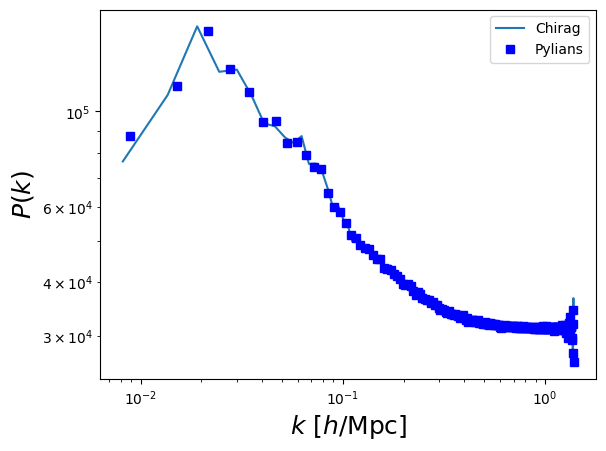

In [134]:
pl.figure()
pl.plot(k_truth_chirag, Pk_truth_chirag, label='Chirag')
# pl.plot(Pk_truth.k3D, Pk_truth.Pk[:,0], label='Pylians', color='b', ls='', marker='s', lw=2.0)
# pl.plot(Pk_truth_new.k3D, Pk_truth_new.Pk[:,0], label='Pylians', color='b', ls='', marker='s', lw=2.0)
pl.plot(Pk_truth_new3.k3D, Pk_truth_new3.Pk[:,0], label='Pylians', color='b', ls='', marker='s', lw=2.0)
# pl.plot(Pk_truth_new2.k3D, Pk_truth_new2.Pk[:,0], label='Pylians', color='b', ls='', marker='s', lw=2.0)
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$k$ [$h$/Mpc]', size=18)
pl.ylabel(r'$P(k)$', size=18)
pl.legend()


In [135]:
import numpy as np
import h5py as h5

with h5.File('/mnt/home/spandey/ceph/AR_NPE/FINAL_run_models/truth_halo_ns' + str(ns_h) + '.h5', 'r') as df:
    pos_h_truth = np.vstack((df['x_h'][()],df['y_h'][()],df['z_h'][()])).T
    lgMass_truth = df['lgMass'][()]
indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
print(len(indsel_Pk_truth))
# df_nbkit = {}
# df_nbkit['Position'] = pos_h_truth[indsel_Pk_truth,...]
# from nbodykit.source.catalog import ArrayCatalog
# cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
# mesh_truth2 = cat.to_mesh(window='nearest', Nmesh=grid, compensated=False, position='Position')
# mesh_truth2 = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')
# r = FFTPower(mesh_truth2, mode='1d', dk=0.05)
# Pk_truth2 = r.power

mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=MAS, threads=1)







31728

Computing power spectrum of the field...
Time to complete loop = 0.54
Time taken = 0.71 seconds


In [136]:
import numpy as np
import h5py as h5
# df = h5.File('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/run_models/mock_halo_ns256.h5', 'r')
# pos_h_mock = np.vstack((df['x_h'][()],df['y_h'][()],df['z_h'][()])).T
# lgMass_mock = df['lgMass_mock'][()]


indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
print(len(indsel_Pk_mock))
# df_nbkit = {}
# df_nbkit['Position'] = pos_h_mock[indsel_Pk_mock,...]

# from nbodykit.source.catalog import ArrayCatalog
# cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
# # mesh_mock = cat.to_mesh(window='nearest', Nmesh=grid, compensated=False, position='Position')
# mesh_mock = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')
# r = FFTPower(mesh_mock, mode='1d', dk=0.05)
# Pk_mock = r.power


mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=MAS, threads=1)







22233

Computing power spectrum of the field...
Time to complete loop = 0.54
Time taken = 0.71 seconds


In [137]:
Pk_mock_new = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)
k_mock_chirag, Pk_mock_chirag = power(mesh_mock+1, boxsize=BoxSize)




Computing power spectrum of the field...
Time to complete loop = 0.46
Time taken = 0.64 seconds


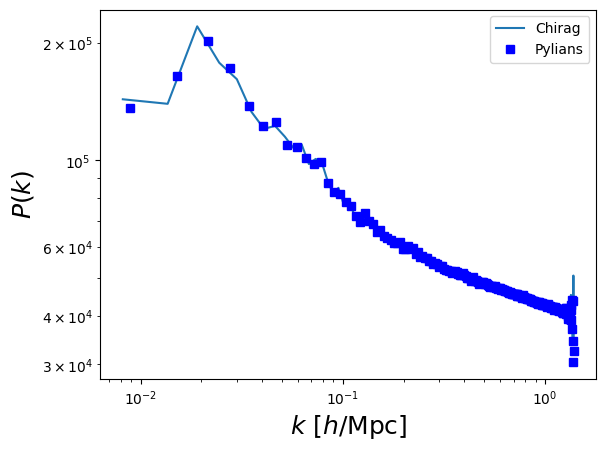

In [138]:
pl.figure()
pl.plot(k_mock_chirag, Pk_mock_chirag, label='Chirag')
# pl.plot(Pk_truth.k3D, Pk_truth.Pk[:,0], label='Pylians', color='b', ls='', marker='s', lw=2.0)
# pl.plot(Pk_truth_new.k3D, Pk_truth_new.Pk[:,0], label='Pylians', color='b', ls='', marker='s', lw=2.0)
pl.plot(Pk_mock_new.k3D, Pk_mock_new.Pk[:,0], label='Pylians', color='b', ls='', marker='s', lw=2.0)
# pl.plot(Pk_truth_new2.k3D, Pk_truth_new2.Pk[:,0], label='Pylians', color='b', ls='', marker='s', lw=2.0)
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$k$ [$h$/Mpc]', size=18)
pl.ylabel(r'$P(k)$', size=18)
pl.legend()


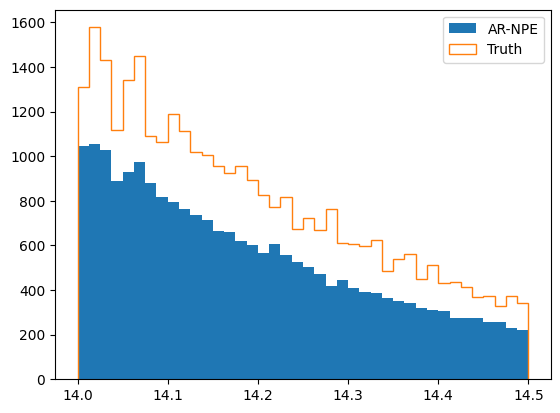

In [139]:
# ns_h
# pos_h_mock
pl.figure()
# _ = pl.hist(lgMass_mock, range=(13.1, 16), bins=40)
# _ = pl.hist(lgMass_truth, range=(13.1, 16),histtype='step', bins=40)
_ = pl.hist(lgMass_mock, range=(Mmin_Pk, np.minimum(Mmax_Pk,16)), bins=40, label='AR-NPE')
_ = pl.hist(lgMass_truth, range=(Mmin_Pk, np.minimum(Mmax_Pk,16)),histtype='step', bins=40, label='Truth')
# pl.yscale('log')
pl.legend()





In [140]:
# r = FFTPower(mesh_truth, second=mesh_mock, mode='1d', dk=0.05)
# Pk_mockxtruth = r.power 
Pk_mockxtruth = PKL.XPk([mesh_truth,mesh_mock], BoxSize, axis=0, MAS=[MAS, MAS], threads=1)


# r = FFTPower(mesh_truth2, second=mesh_mock, mode='1d', dk=0.05)
# Pk_mockxtruth2 = r.power
Pk_mockxtruth2 = PKL.XPk([mesh_truth2,mesh_mock], BoxSize, axis=0, MAS=[MAS, MAS], threads=1)
# r = FFTPower(mesh_mock, second=mesh_truth2, mode='1d', dk=0.05)
# Pk_mockxtruth2 = r.power


# r = FFTPower(mesh_truth2, second=mesh_mock, mode='1d', dk=0.05)
# Pk_mockxtruth2 = r.power
# r = FFTPower(mesh_truth, second=mesh_truth2, mode='1d', dk=0.05)
# Pk_truthxtruth2 = r.power
Pk_truthxtruth2 = PKL.XPk([mesh_truth2,mesh_truth], BoxSize, axis=0, MAS=[MAS, MAS], threads=1)







Computing power spectra of the fields...
Time FFTS = 0.40
Time loop = 0.33
Time taken = 0.73 seconds

Computing power spectra of the fields...
Time FFTS = 0.38
Time loop = 0.33
Time taken = 0.72 seconds

Computing power spectra of the fields...
Time FFTS = 0.40
Time loop = 0.33
Time taken = 0.73 seconds


In [141]:
k_mockxtruth_chirag, Pk_mockxtruth_chirag = power(mesh_truth+1, mesh_mock+1, boxsize=BoxSize)
Pk_mockxtruth_new = PKL.XPk([mesh_truth+1,mesh_mock+1], BoxSize, axis=0, MAS=[None, None], threads=1)

# mesh_mock
# mesh_truth2


Computing power spectra of the fields...
Time FFTS = 0.38
Time loop = 0.33
Time taken = 0.71 seconds


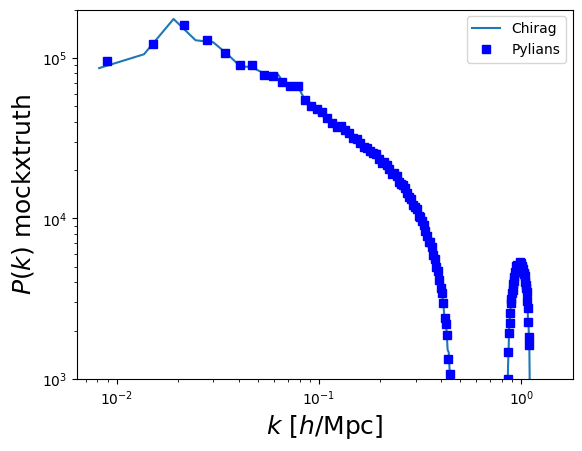

In [142]:
pl.figure()
pl.plot(k_mockxtruth_chirag, Pk_mockxtruth_chirag, label='Chirag')
# pl.plot(Pk_mockxtruth.k3D, Pk_mockxtruth.Pk[:,0,0], label='Pylians', color='b', ls='', marker='s', lw=2.0)
pl.plot(Pk_mockxtruth_new.k3D, Pk_mockxtruth_new.XPk[:,0,0], label='Pylians', color='b', ls='', marker='s', lw=2.0)
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$k$ [$h$/Mpc]', size=18)
pl.ylabel(r'$P(k)$ mockxtruth', size=18)
pl.ylim(1e3, 2e5)
pl.legend()




In [143]:
import pickle as pk
pk.dump({'mesh_truth':mesh_truth, 'mesh_mock':mesh_mock, 'mesh_truth_vox':mesh_truth2}, open('meshes_for_Pk.npy','wb'))



Text(0.5, 0, '$k$ [$h$/Mpc]')

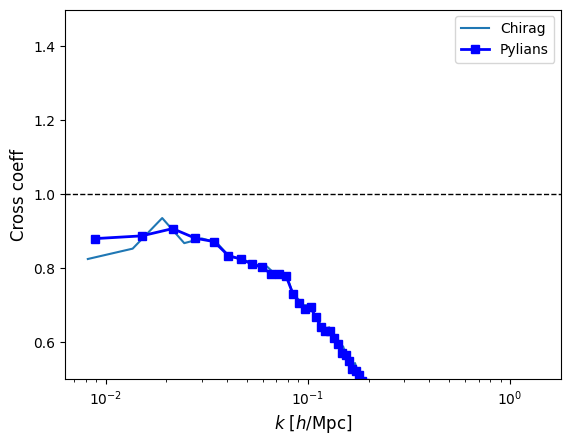

In [144]:
pl.figure()
pl.plot(k_mockxtruth_chirag, Pk_mockxtruth_chirag/(np.sqrt(Pk_truth_chirag * Pk_mock_chirag)), label='Chirag')
# pl.plot(Pk_mockxtruth.k3D, (Pk_mockxtruth.Pk[:,0,0]) / (((Pk_mock.Pk[:,0]) * (Pk_truth.Pk[:,0])) ** 0.5), label='Pylians', color='b', ls='-', marker='s', lw=2.0)
pl.plot(Pk_mockxtruth_new.k3D, (Pk_mockxtruth_new.XPk[:,0,0]) / (((Pk_mock_new.Pk[:,0]) * (Pk_truth.Pk[:,0])) ** 0.5), label='Pylians', color='b', ls='-', marker='s', lw=2.0)
pl.ylim(0.5, 1.5)
pl.xscale('log')
pl.legend()
pl.axhline(1.0, color='k', ls='--', lw=1)
pl.ylabel('Cross coeff',size=12)
pl.xlabel(r'$k$ [$h$/Mpc]', size=12)


Text(0.5, 1.0, 'AR-NPE')

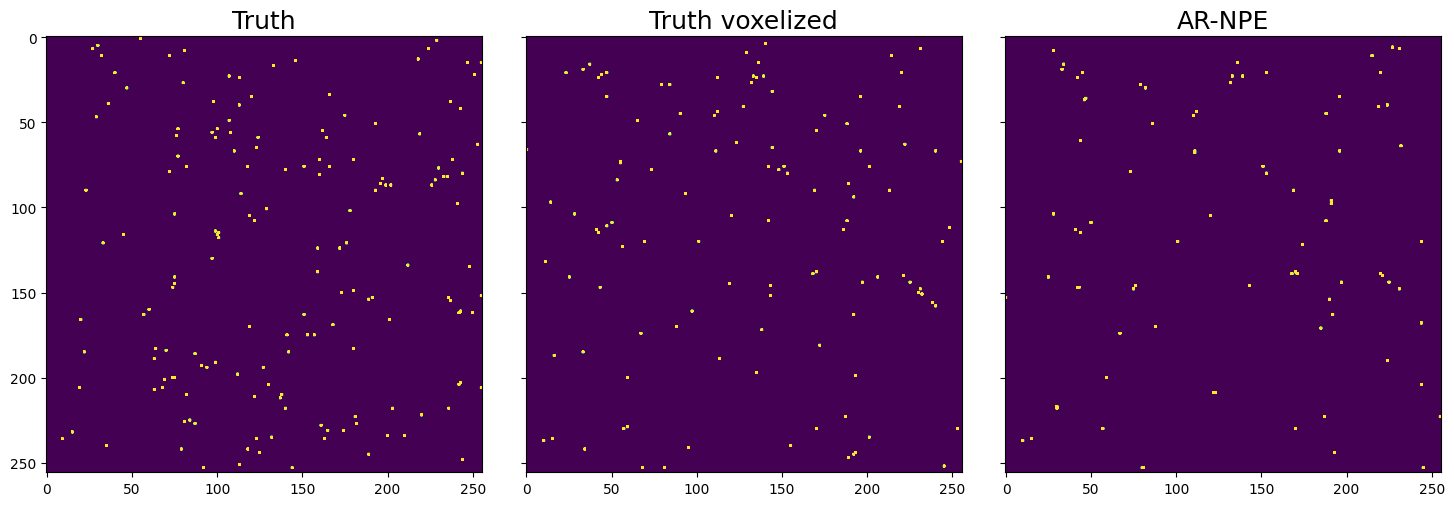

In [145]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))), vmin=-1.0, vmax=200.0)
axes[0].imshow(((mesh_truth[64,...])), vmin=-1.0, vmax=10.0)
axes[0].set_title('Truth', size=18)
# axes[0].imshow(((mesh_mock.preview(axes=[0,1]) - mesh_truth2.preview(axes=[0,1]))), vmin=-1.0, vmax=200.0)
# axes[0].set_title('AR-NPE', size=18)

# axes[1].imshow(((mesh_truth2.preview(axes=[0,1]))), vmin=-1.0, vmax=200.0)
axes[1].imshow(((mesh_truth2[64,...])), vmin=-1.0, vmax=10.0)
axes[1].set_title('Truth voxelized', size=18)
# axes[2].imshow(((mesh_mock.preview(axes=[0,1]))), vmin=-1.0, vmax=200.0)
axes[2].imshow(((mesh_mock[64,...])), vmin=-1.0, vmax=10.0)
axes[2].set_title('AR-NPE', size=18)






(0.0, 32.0)

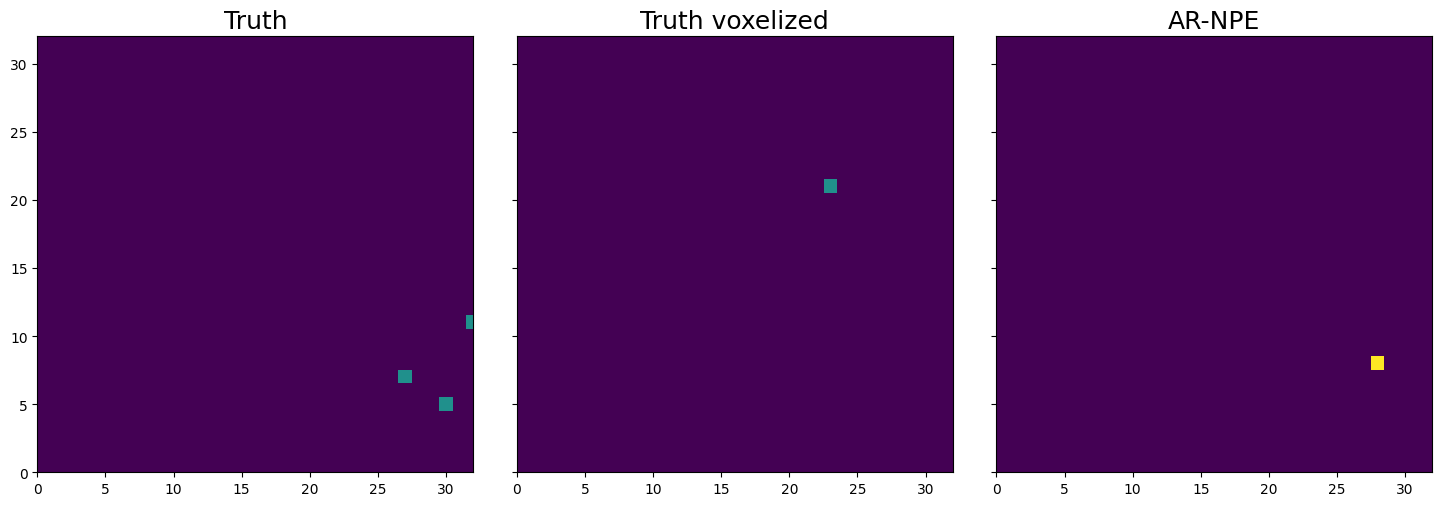

In [146]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
xmin = 0
xmax = 32
# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
axes[0].imshow(((mesh_truth[64,...])))
axes[0].set_title('Truth', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)
# axes[1].imshow(((mesh_truth2.preview(axes=[0,1]))))
axes[1].imshow(((mesh_truth2[64,...])))
axes[1].set_title('Truth voxelized', size=18)
axes[1].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)
# axes[2].imshow(((mesh_mock.preview(axes=[0,1]))))
axes[2].imshow(((mesh_mock[64,...])))
axes[2].set_title('AR-NPE', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)




In [147]:
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 18), sharex=True)
# fig.subplots_adjust(wspace=0.1, hspace=0.1)
# # First subplot
# axes[0].loglog(Pk_truth['k'], Pk_truth['power'].real - Pk_truth.attrs['shotnoise'], label='Truth', color='b', ls='', marker='s', lw=2.0)
# axes[0].loglog(Pk_truth2['k'], Pk_truth2['power'].real - Pk_truth2.attrs['shotnoise'], label='Truth-voxelized', color='r', ls='', marker='D', lw=2.0)
# axes[0].loglog(Pk_mock['k'], (Pk_mock['power'].real - Pk_mock.attrs['shotnoise']), label='AR-NPE', color='k', ls='-', marker='o', lw=2.0)


# # axes[0].loglog(Pk_truth['k'], Pk_truth['power'].real, label='Truth', color='b', ls='', marker='s', lw=2.0)
# # axes[0].loglog(Pk_truth2['k'], Pk_truth2['power'].real, label='Truth-voxelized', color='r', ls='', marker='D', lw=2.0)
# # axes[0].loglog(Pk_mock['k'], (Pk_mock['power'].real), label='AR-NPE', color='k', ls='-', marker='o', lw=2.0)

# axes[0].legend(fontsize=16, loc='lower left')
# # axes[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=22)
# axes[0].set_ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]", size=18)
# # axes[0].set_title(str(Mmin_Pk) + r'$< \log(M) <$' + str(Mmax_Pk), size=18)
# axes[0].tick_params(axis='both', labelsize=15)
# # Second subplot
# # axes[1].plot(Pk_mock['k'], (Pk_mock['power'].real - Pk_mock.attrs['shotnoise']) / (Pk_truth['power'].real  - Pk_truth.attrs['shotnoise'] ), label='AR-NPE/Truth', color='b', ls='-', marker='o', lw=2.0)
# # axes[1].plot(Pk_mock['k'], (Pk_mock['power'].real - Pk_mock.attrs['shotnoise']) / (Pk_truth2['power'].real - Pk_truth2.attrs['shotnoise'] ), label='AR-NPE/Truth-voxelized', color='r', ls='--', marker='D', lw=2.0)

# axes[1].plot(Pk_mock['k'], (Pk_mock['power'].real) / (Pk_truth['power'].real), label='AR-NPE/Truth', color='b', ls='-', marker='o', lw=2.0)
# axes[1].plot(Pk_mock['k'], (Pk_mock['power'].real) / (Pk_truth2['power'].real), label='AR-NPE/Truth-voxelized', color='r', ls='--', marker='D', lw=2.0)


# axes[1].legend(fontsize=16, loc='lower left')
# # axes[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=22)
# axes[1].set_ylabel(r"$P(k)$ ratio", size=18)
# axes[1].axhline(1.0, ls='--', color='k')
# axes[1].set_ylim(0.8, 1.2)
# axes[1].tick_params(axis='both', labelsize=15)
# # axes[1].set_title(str(Mmin_Pk) + r'$< \log(M) <$' + str(Mmax_Pk), size=20)

# # Third subplot
# axes[2].plot(Pk_mockxtruth['k'], (Pk_mockxtruth['power'].real) / (((Pk_mock['power'].real) * (Pk_truth['power'].real)) ** 0.5), label='Truth x AR-NPE', color='b', ls='-', marker='s', lw=2.0)
# axes[2].plot(Pk_mockxtruth2['k'], (Pk_mockxtruth2['power'].real) / (((Pk_mock['power'].real) * (Pk_truth2['power'].real)) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='--', marker='D', lw=2.0)
# # axes[2].plot(Pk_truthxtruth2['k'], (Pk_truthxtruth2['power'].real) / (((Pk_truth['power'].real) * (Pk_truth2['power'].real)) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='--', marker='s', lw=2.0)
# # axes[2].set_ylim(0.9, 1.1)
# axes[2].axhline(1.0, ls='--', color='k')
# axes[2].set_xscale('log')
# axes[2].legend(fontsize=16)
# axes[2].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
# axes[2].set_ylabel(r"Cross-coeff", size=18)
# axes[2].tick_params(axis='both', labelsize=15)
# plt.tight_layout()
# # plt.savefig('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/figs/power_comp_ns_' + str(ns_h) + '_lgM' + str(Mmin_Pk) + '_' + str(Mmax_Pk) + '.png', dpi=300) 

                   

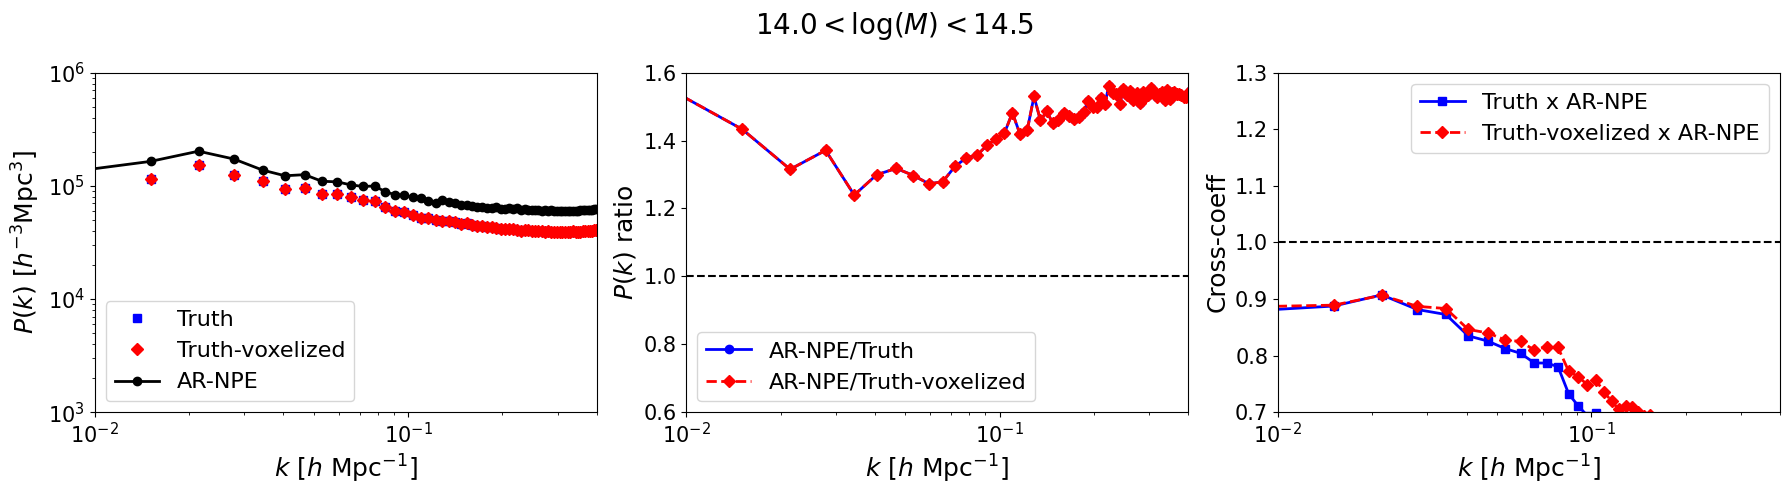

In [148]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
# First subplot
axes[0].loglog(Pk_truth.k3D, Pk_truth.Pk[:,0], label='Truth', color='b', ls='', marker='s', lw=2.0)
axes[0].loglog(Pk_truth2.k3D, Pk_truth2.Pk[:,0], label='Truth-voxelized', color='r', ls='', marker='D', lw=2.0)
axes[0].loglog(Pk_mock.k3D, Pk_mock.Pk[:,0], label='AR-NPE', color='k', ls='-', marker='o', lw=2.0)
# axes[0].set_ylim(1e3, 1e5)
axes[0].set_ylim(1e3, 1e6)

# axes[0].loglog(Pk_truth['k'], Pk_truth['power'].real, label='Truth', color='b', ls='', marker='s', lw=2.0)
# axes[0].loglog(Pk_truth2['k'], Pk_truth2['power'].real, label='Truth-voxelized', color='r', ls='', marker='D', lw=2.0)
# axes[0].loglog(Pk_mock['k'], (Pk_mock['power'].real), label='AR-NPE', color='k', ls='-', marker='o', lw=2.0)

axes[0].legend(fontsize=16, loc='lower left')
# axes[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=22)
axes[0].set_ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]", size=18)
# axes[0].set_title(str(Mmin_Pk) + r'$< \log(M) <$' + str(Mmax_Pk), size=18)
axes[0].tick_params(axis='both', labelsize=15)
# Second subplot
# axes[1].plot(Pk_mock['k'], (Pk_mock['power'].real - Pk_mock.attrs['shotnoise']) / (Pk_truth['power'].real  - Pk_truth.attrs['shotnoise'] ), label='AR-NPE/Truth', color='b', ls='-', marker='o', lw=2.0)
# axes[1].plot(Pk_mock['k'], (Pk_mock['power'].real - Pk_mock.attrs['shotnoise']) / (Pk_truth2['power'].real - Pk_truth2.attrs['shotnoise'] ), label='AR-NPE/Truth-voxelized', color='r', ls='--', marker='D', lw=2.0)

axes[1].plot(Pk_mock.k3D, Pk_mock.Pk[:,0]/ Pk_truth.Pk[:,0], label='AR-NPE/Truth', color='b', ls='-', marker='o', lw=2.0)
axes[1].plot(Pk_mock.k3D, Pk_mock.Pk[:,0]/ Pk_truth2.Pk[:,0], label='AR-NPE/Truth-voxelized', color='r', ls='--', marker='D', lw=2.0)


axes[1].legend(fontsize=16, loc='lower left')
# axes[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=22)
axes[1].set_ylabel(r"$P(k)$ ratio", size=18)
axes[1].axhline(1.0, ls='--', color='k')
# axes[1].set_ylim(0.8, 1.2)
axes[1].set_ylim(0.6, 1.6)
axes[1].tick_params(axis='both', labelsize=15)


# Third subplot
# axes[2].plot(Pk_mockxtruth['k'], (Pk_mockxtruth['power'].real) / (((Pk_mock['power'].real) * (Pk_truth['power'].real)) ** 0.5), label='Truth x AR-NPE', color='b', ls='-', marker='s', lw=2.0)
# axes[2].plot(Pk_mockxtruth2['k'], (Pk_mockxtruth2['power'].real) / (((Pk_mock['power'].real) * (Pk_truth2['power'].real)) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='--', marker='D', lw=2.0)
axes[2].plot(Pk_mockxtruth.k3D, (Pk_mockxtruth.XPk[:,0,0]) / (((Pk_mock.Pk[:,0]) * (Pk_truth.Pk[:,0])) ** 0.5), label='Truth x AR-NPE', color='b', ls='-', marker='s', lw=2.0)
axes[2].plot(Pk_mockxtruth2.k3D, (Pk_mockxtruth2.XPk[:,0,0]) / (((Pk_mock.Pk[:,0]) * (Pk_truth2.Pk[:,0])) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='--', marker='D', lw=2.0)


# axes[2].plot(Pk_truthxtruth2['k'], (Pk_truthxtruth2['power'].real) / (((Pk_truth['power'].real) * (Pk_truth2['power'].real)) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='--', marker='s', lw=2.0)
# axes[2].set_ylim(0.9, 1.1)
axes[2].set_ylim(0.7, 1.3)
axes[2].axhline(1.0, ls='--', color='k')
axes[2].set_xscale('log')
axes[2].legend(fontsize=16)
axes[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
axes[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
axes[2].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
axes[2].set_ylabel(r"Cross-coeff", size=18)
axes[2].tick_params(axis='both', labelsize=15)
axes[2].set_xlim(0.01, 0.4)
plt.suptitle(str(Mmin_Pk) + r'$< \log(M) <$' + str(Mmax_Pk), size=20)
plt.tight_layout()
# plt.savefig('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/figs/power_comp_ns_' + str(ns_h) + '_lgM' + str(Mmin_Pk) + '_' + str(Mmax_Pk) + '.png', dpi=300) 
# plt.savefig('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/figs/power_comp_ns_' + str(ns_h) + '_lgM' + str(Mmin_Pk) + '_' + str(Mmax_Pk) + '.png', dpi=300) 


                   

In [81]:
(((Pk_mock.Pk[:,0]) * (Pk_truth.Pk[:,0])) ** 0.5).shape


(221,)

In [393]:
import readfof
import MAS_library as MASL
snap_dir_base='/mnt/home/spandey/ceph/Quijote/Halos/fiducial'
# load the corresponding halo catalogue
snapdir = snap_dir_base + '/' + str(0)  #folder hosting the catalogue
snapnum=4
# determine the redshift of the catalogue
# z_dict = {4: 0.0, 3: 0.5, 2: 1.0, 1: 2.0, 0: 3.0}
# redshift = z_dict[snapnum]

# read the halo catalogue
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)

# get the properties of the halos
pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

lgMass_truth = np.log10(mass_truth)

# Mmin_Pk, Mmax_Pk = 13.0, 100.0
Mmin_Pk, Mmax_Pk = 14.0, 14.5
# Mmin_Pk, Mmax_Pk = 13.5, 14.0
# Mmin_Pk, Mmax_Pk = 14.5, 16.0
# Mmin_Pk, Mmax_Pk = 13, 16
indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]

print(len(indsel_Pk_truth))
# density field parameters
grid    = ns_h    #the 3D field will have grid x grid x grid voxels
BoxSize = 1000.0 #Mpc/h ; size of box
MAS     = 'NGP'  #mass-assigment scheme
verbose = True   #print information on progress

mesh_truth = np.zeros((grid, grid, grid), dtype=np.float32)
pos_truth = pos_h_truth[indsel_Pk_truth,...]
MASL.MA(pos_truth, mesh_truth, BoxSize, MAS)
mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
Pk_truth = PKL.Pk(mesh_truth, BoxSize, axis=0, MAS=MAS, threads=1)




(221,)